# transfer learning with fine tuning technique

![transfer learning](./assets/transfer_learning.png)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [5]:

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
        
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
        
    ])
}

In [29]:
train_dataset =  datasets.ImageFolder(
    root="./data/transer_learning/hymenoptera_data/train",
    transform=data_transform["train"]
)
class_names = train_dataset.classes
train_dataset.classes

['ants', 'bees']

In [26]:
dataset_path = "./data/transer_learning/hymenoptera_data/"
dataset = {
x : datasets.ImageFolder(
        root= dataset_path + x,
        transform= data_transform[x]
)

for x in ['train','val']

}

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 244, 'val': 153}

In [22]:
dataset['train'].samples[:1],dataset['val'].samples[:1]

([('./data/transer_learning/hymenoptera_data/train\\ants\\0013035.jpg', 0)],
 [('./data/transer_learning/hymenoptera_data/val\\ants\\10308379_1b6c72e180.jpg',
   0)])

In [20]:
dataset['train'][0]


(tensor([[[-0.6980, -0.7137, -0.6980,  ..., -0.7922, -0.7922, -0.8078],
          [-0.7137, -0.7137, -0.7137,  ..., -0.7765, -0.7922, -0.7922],
          [-0.6980, -0.7137, -0.7294,  ..., -0.7922, -0.7765, -0.7608],
          ...,
          [-0.6353, -0.6196, -0.6196,  ..., -1.0431,  1.0431, -0.1490],
          [-0.6353, -0.6196, -0.6196,  ..., -1.6078,  0.7765,  0.0706],
          [-0.6353, -0.6196, -0.6196,  ...,  0.7765,  1.4353, -0.8078]],
 
         [[ 0.3686,  0.4000,  0.4157,  ...,  0.3059,  0.3216,  0.3059],
          [ 0.3686,  0.4000,  0.4000,  ...,  0.3216,  0.3216,  0.3216],
          [ 0.3843,  0.4000,  0.3843,  ...,  0.3059,  0.3216,  0.3529],
          ...,
          [ 0.4784,  0.4941,  0.4941,  ..., -1.0431,  1.0431, -0.1490],
          [ 0.4784,  0.4941,  0.4941,  ..., -1.6078,  0.7765,  0.0706],
          [ 0.4784,  0.4941,  0.4941,  ...,  0.7765,  1.4353, -0.8078]],
 
         [[ 1.6706,  1.6863,  1.7020,  ...,  1.6235,  1.6078,  1.5922],
          [ 1.6706,  1.6863,

# DataLoader

In [23]:
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

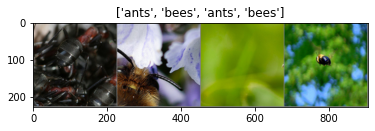

In [31]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [32]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

inputs.shape,classes.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

# Getting Preetrained Model for the Classification

In [44]:

#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)

In [45]:

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## changing the fc layer to 2 since we have to classify to class

In [46]:
num_ftrs = model.fc.in_features

num_ftrs


512

In [47]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Criterian and Optimizer

In [48]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training Loop

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5821 Acc: 0.6967
val Loss: 0.4476 Acc: 0.8431

Epoch 1/1
----------
train Loss: 0.4799 Acc: 0.8033
val Loss: 0.3384 Acc: 0.8889

Training complete in 1m 57s
Best val Acc: 0.888889


# Training only the selected layers


In [51]:

#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.6181 Acc: 0.7172
val Loss: 0.2755 Acc: 0.8824

Epoch 1/3
----------
train Loss: 0.5168 Acc: 0.7828
val Loss: 0.1971 Acc: 0.9412

Epoch 2/3
----------
train Loss: 0.5204 Acc: 0.7582
val Loss: 0.1792 Acc: 0.9477

Epoch 3/3
----------
train Loss: 0.5685 Acc: 0.7705
val Loss: 0.3507 Acc: 0.8693

Training complete in 1m 38s
Best val Acc: 0.947712
